In [1]:
## Import needed mods
import numpy as np, pandas as pd, glob
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
## Write a ftn to plot diagnostics
def plot_chroms(df,chrom_list,x='AF',y='Lognq',centros=None,
               xl = 'Chromosome Coordinate (kb)',
               yl='$log_{10}$(Quality / Depth)',kb=1000.0,
                fs=18,ms=0.5,Type ='snp',pl='k.',fl=2,fw=7,
                vl=[3.7,3.1]):
    fig, ax  = plt.subplots(fl,fw,figsize=(20,5),sharey=True)
    for c, chrom in enumerate(chrom_list):
        temp = df[(df.Chrom==chrom)&(df.Type==Type)]
        plt.sca(ax.ravel()[c]);
        plt.plot(temp[x].values,temp[y].values,pl,ms=ms);
        if centros is not None:
            plt.vlines(centros.T[chrom].values,vl[0],vl[1],color='r',linewidth=0.5);
    fig.text(0.1,0.5,yl,fontsize=fs,rotation =90,ha = 'center',va='center');
    fig.text(0.5,0.01,xl,fontsize=fs,ha='center',va='center');

In [3]:
## Set paths to genotype information
gvs_filepath = '../DATA/GENOTYPE/CDX_illumina_vcf/DFRAME/GT/CDx-ill-gvs.csv.gz'
ads_filepath = '../DATA/GENOTYPE/CDX_illumina_vcf/DFRAME/AD/CDx-ill-ads.csv.gz'

## chromosome centromeres and sample info
centromere_path = '../DATA/XL280-centromere-locs.csv'
cross_infopath = '../DATA/CDX_Sample_Info.csv'

In [ ]:
## Bring in chromosome map
chrommap_path = '../DATA/XL280-chrom-map.csv'
chrommap = pd.read_csv(chrommap_path)
chrommap.head()

In [ ]:
## Gather unique chromosome lengths
chromosome_lengths = chrommap.Length.values

assert len(chromosome_lengths) == 14

In [4]:
## Set variables
kb = 1000.0
                   
## Identified clones (to keep) in crosses
clone_keep_1_illix = [4,5,7,13,46,49,72]
clone_keep_2_illix = [10,106,35,66,76] ## we removed 34 here to keep 'SS-317' 

In [ ]:
## Bring in genotype and allelic read depth dataframes
gts_dfs = pd.read_csv(gvs_filepath,
                      index_col=0,header=0)
gts_dfs.head()

In [8]:
## Make a chromosome list
chrom_list = gts_dfs.Chrom.unique()
len(chrom_list)

14

In [9]:
## Load in centromeres
centros = pd.read_csv(centromere_path,index_col=0)
centros.columns = ['v','w']

In [10]:
## Devide by one kb. 
centros[['v','w']] = centros[['v','w']]/kb

In [11]:
## Load in cross information
cross_info = pd.read_csv(cross_infopath,index_col=0)

In [12]:
cross_info.shape

(127, 10)

In [13]:
cross_info[(cross_info.Code==1)].shape

(61, 10)

In [14]:
cross_info[(cross_info.Code==2)].shape

(63, 10)

In [15]:
cross_info[(cross_info.Aneuploidy == 1)].shape

(6, 10)

In [16]:
## Here i'm adding 'SS-B593' as a "clone", this segregant is non-recombinant. 
cross_info.loc[cross_info.Strain=='SS-B593','is_clone'] = 1

In [17]:
## Who is not a clone?
not_clone = cross_info[(cross_info.is_clone==0)]['Ill-index'].values.tolist()

In [18]:
## Who has an aneuploid chromosome? 
is_aneuploid = cross_info[(cross_info.Aneuploidy==1)]['Ill-index'].values.tolist()

In [19]:
## Who is a clone?
is_clone = cross_info[(cross_info.is_clone==1)]['Ill-index'].values.tolist()

In [20]:
## Gather the segregants we will use who are unique (with both possible clones and aneuplidy)
segs_possible_aneu_ill_ix = not_clone + clone_keep_1_illix + clone_keep_2_illix

In [21]:
## Make sure these are unique
assert len(segs_possible_aneu_ill_ix) == len(np.unique(segs_possible_aneu_ill_ix))

In [22]:
## Take segregants if they are not aneuplid for any chromosome
segs_ill_ix = [s for s in segs_possible_aneu_ill_ix if s not in is_aneuploid]

In [23]:
## Check that we have dropped enough of the aneuploid segregants
assert len(segs_ill_ix) <= len(segs_possible_aneu_ill_ix)

In [24]:
## How many segregatns are we using that have a clone?
len([s for s in is_clone if s in segs_ill_ix])

10

In [25]:
## How many segregants are we using?
len(segs_ill_ix)

104

In [26]:
## Find the baddies. 
baddies = [a for a in cross_info['Ill-index'].values if a not in segs_ill_ix] 

In [27]:
## how man segregants are we dropping?
len(baddies)

23

In [28]:
## make a dataframe for those segregants we are not including
baddydf = cross_info[(cross_info['Ill-index'].isin(baddies))]

In [29]:
sum(baddydf[['Aneuploidy','is_clone']].sum(axis=1) >= 1) 

23

In [30]:
## Check that these are all bad
assert sum(baddydf[['Aneuploidy','is_clone']].sum(axis=1) >= 1) == len(baddies)

In [31]:
## take names to drop
bad_names = baddydf['Ill-name'].tolist()

In [32]:
## take info for the segregatns we are using here
this_cross = cross_info[(cross_info['Ill-index'].isin(segs_ill_ix))].copy()

In [33]:
## check our assumptions and work
assert this_cross.Aneuploidy.sum() == 0
assert this_cross.is_clone.sum() <= (len(clone_keep_1_illix) + len(clone_keep_2_illix))

In [34]:
## seperate segregatns (by cross) and parents 
bi_cross = this_cross[this_cross.Code == 1][u'Ill-name'].tolist()
print("Bi:",len(bi_cross))
un_cross = this_cross[this_cross.Code == 2][u'Ill-name'].tolist()
print("Uni:",len(un_cross))
parental = this_cross[this_cross.Code > 2][u'Ill-name'].tolist()
print("Parental:",len(parental))

Bi: 46
Uni: 55
Parental: 3


In [35]:
## DROP segregatns that are clones we are not keeping or have aneuploidy
if bad_names[0] in gts_dfs.columns.tolist():
    gts_dfs.drop(bad_names,axis=1,inplace=True)

In [36]:
## Drop sites with missing values
gts_dfs.dropna(inplace=True)
gts_dfs.shape

(564039, 114)

In [37]:
## Make a list of the cumalitive chromosome length sums
chrom_cum_sum = np.array([0] + list(np.cumsum(chromosome_lengths[:-1])))

In [38]:
## Calculate a cumulative sum vector
cum_choms_pos = np.concatenate([gts_dfs[(gts_dfs.Chrom==chrom)].Pos.values + chrom_cum_sum[c] 
             for c, chrom in enumerate(chrom_list)])

In [39]:
## Add cumulative sum
gts_dfs['Cum_pos'] = cum_choms_pos
gts_dfs['Posk'] = gts_dfs.Pos.values/kb

In [40]:
## Log10 transform read depth
gts_dfs['Logdp'] = np.log10(gts_dfs['Dp'].values)

In [41]:
## Log10 transform data quality score devided by depth
gts_dfs['Lognq'] = np.log10(gts_dfs['Qual'].values/(gts_dfs['Dp'].values))

/Users/croth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [42]:
## Calculate allelic frequency
gts_dfs['AF']  = gts_dfs[this_cross['Ill-name'].tolist()].sum(axis=1)/float(len(this_cross['Ill-name']))

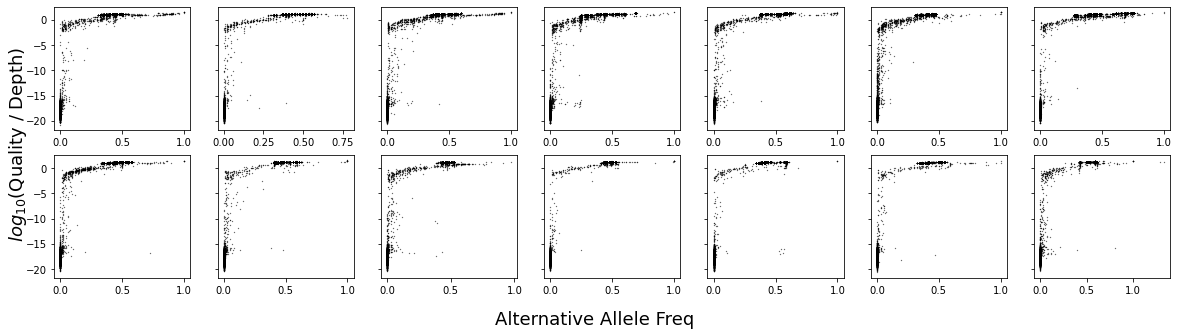

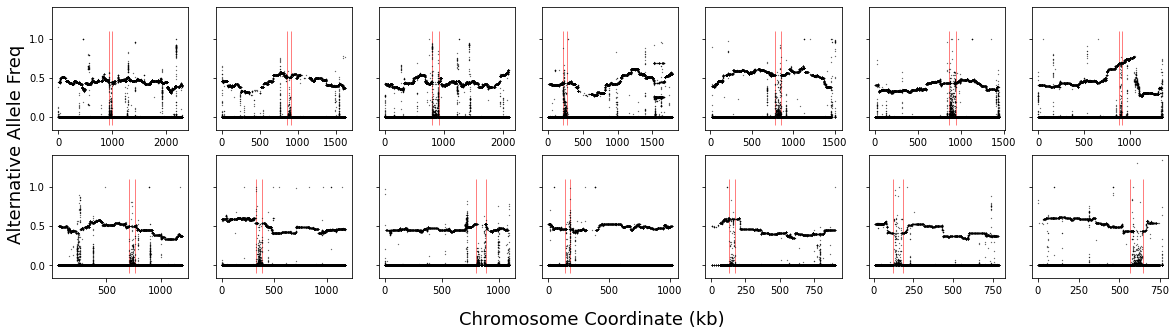

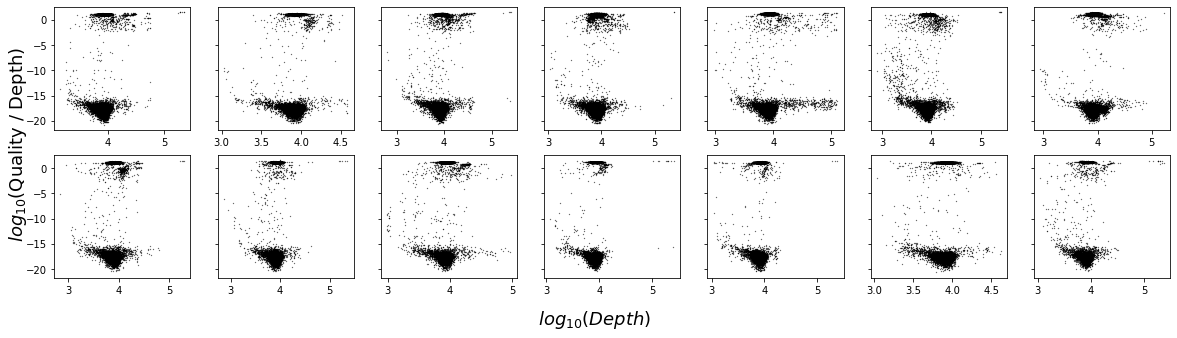

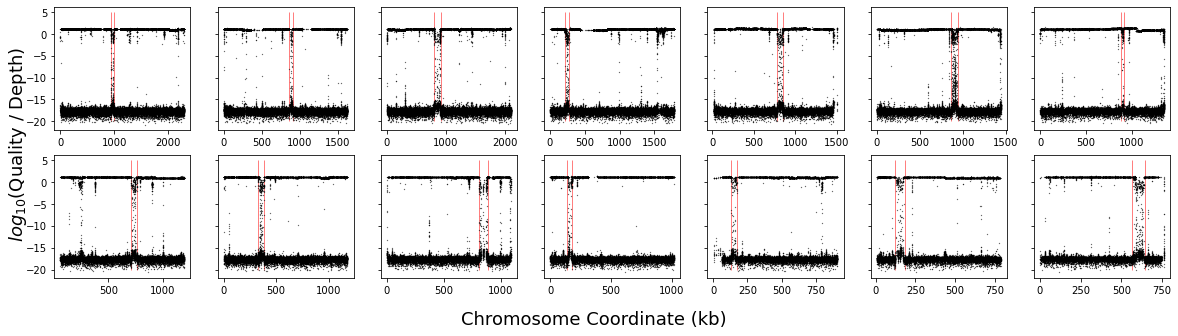

In [43]:
## Diagnostic plots
plot_chroms(gts_dfs,chrom_list,xl='Alternative Allele Freq',x='AF')
plot_chroms(gts_dfs,chrom_list,x='Posk',y='AF',yl='Alternative Allele Freq',centros=centros,vl=[-0.1,1.1])
plot_chroms(gts_dfs,chrom_list,xl='$log_{10}(Depth)$',x='Logdp')
plot_chroms(gts_dfs,chrom_list,x='Posk',centros=centros,vl=[-20,5])

In [44]:
## Set positional filters
telofilt = 5*kb
centfilt = 5*kb

In [45]:
## Find genetic variant sites within teleomeres, 5' side
left_pos_out = gts_dfs[(gts_dfs.Pos<=telofilt)].index.tolist()

In [46]:
## Find genetic variant sites within temeomeres 3' side
right_pos_out = list(np.concatenate([gts_dfs[(gts_dfs.Chrom==chrom) & 
                                        (gts_dfs.Pos 
                                         >= chromosome_lengths[c] - telofilt)].index.tolist() 
                                for c, chrom in enumerate(chrom_list)]))

In [47]:
## Find genetic variant sites in and 5 kb near centromeres 
cent_out =  list(np.concatenate([gts_dfs[(gts_dfs.Chrom==chrom) & 
                                    (gts_dfs.Pos >= (centros.T[chrom]['v']*kb) - centfilt) &
                                    (gts_dfs.Pos <= (centros.T[chrom]['w']*kb) + centfilt)
                                         ].index.tolist() 
                                for c, chrom in enumerate(chrom_list)]))

In [48]:
## Drop sites in or near teleomeres or centromeres 
gts_dfs.drop(left_pos_out+right_pos_out+cent_out,inplace=True)

In [49]:
## Set thresholds and filtering values
#gv_type = 'snp' # Here I want both indels and snps - Cullen Roth, Feb 13 2019
alt_len = 1
covX = 10.0
call_rate = 1.0
log_norm_qu = -5
alt_minor_alf = 0.2
ref_minor_alf = 0.8

In [50]:
#gts_dfs[(gts_dfs['Altlen']==alt_len) & (gts_dfs['Type']==gv_type) & (gts_dfs['Callrate']==call_rate)].shape

In [51]:
## Basic filtering, bi-allelic snps, with average depth persite 10X, 100% callrate, and quality score. 
snp_gt = gts_dfs[#(gts_dfs['Type']==gv_type) & 
                (gts_dfs['Altlen']==alt_len) &
                (gts_dfs['Dp'] >= covX*len(segs_ill_ix)) & 
                (gts_dfs['Callrate']==call_rate) & 
                (gts_dfs['Lognq']>log_norm_qu) & 
                (gts_dfs['AF']>=alt_minor_alf) & ## Minor allele freq of 0.2
                (gts_dfs['AF']<=ref_minor_alf) & ## Non segregating sites with alt allele
                (gts_dfs[parental[0]] != gts_dfs[parental[1]]) & ## where 431alpha and xl280alpha are different
                (gts_dfs[parental[-1]] == gts_dfs[parental[1]])].copy() ## Where xl280a and xl280alhpa are the same

In [52]:
snp_gt.shape

(96478, 119)

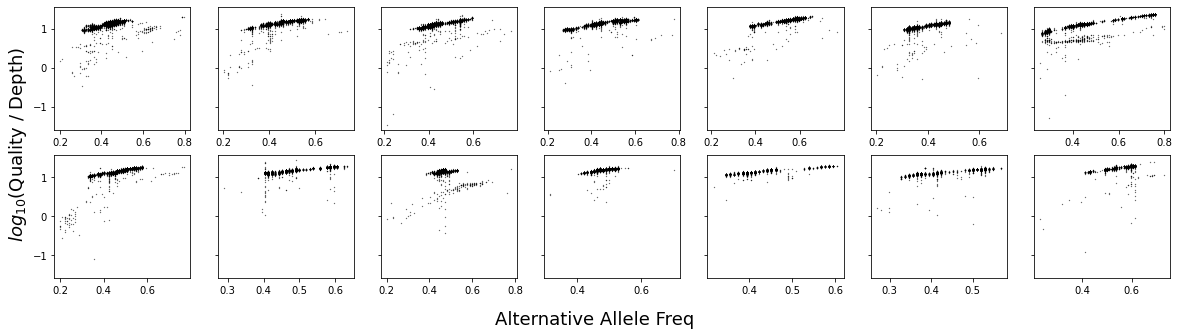

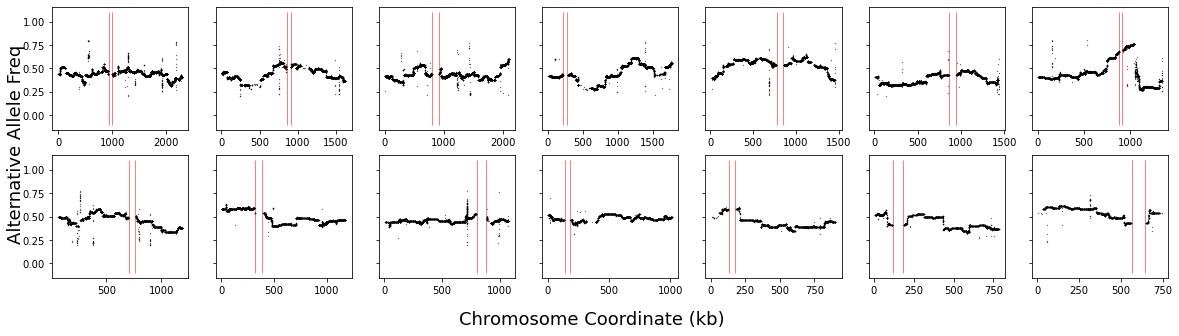

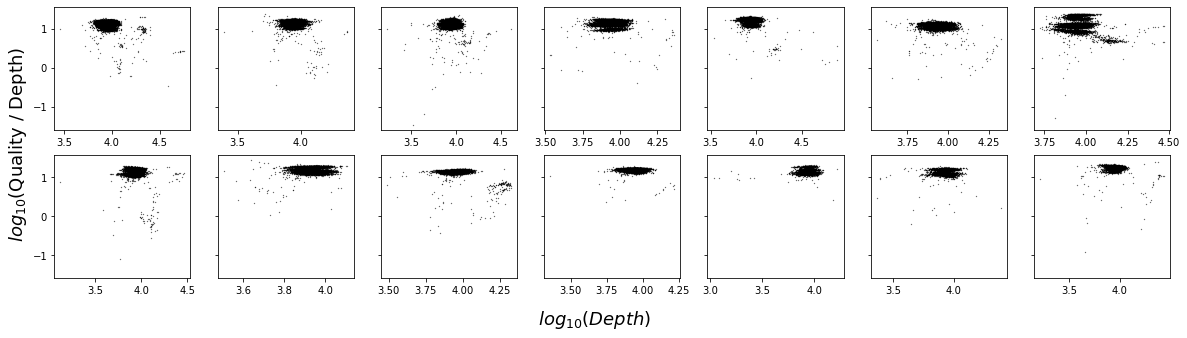

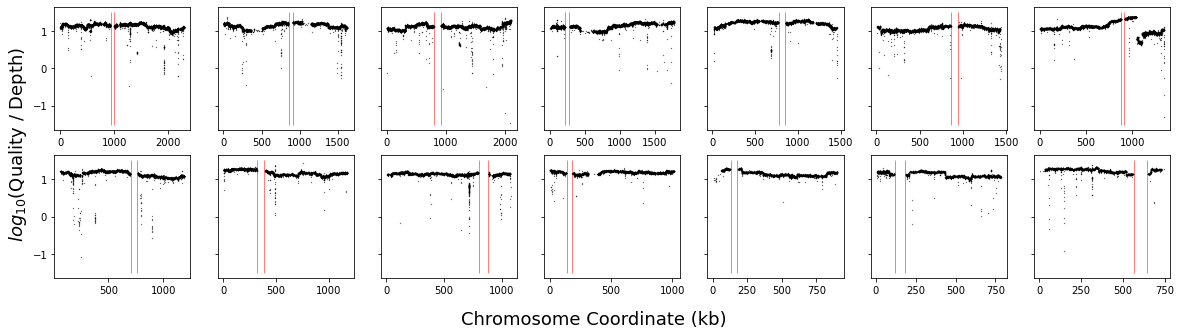

In [53]:
## Diagnostic plots
plot_chroms(snp_gt,chrom_list,xl='Alternative Allele Freq',x='AF')
plot_chroms(snp_gt,chrom_list,x='Posk',y='AF',yl='Alternative Allele Freq',centros=centros,vl=[-0.1,1.1])
plot_chroms(snp_gt,chrom_list,xl='$log_{10}(Depth)$',x='Logdp')
plot_chroms(snp_gt,chrom_list,x='Posk',centros=centros,vl=[-1.5,1.5])

In [54]:
## gather index
snp_gt_ix = snp_gt.index.tolist()

In [56]:
## Bring in genotype and allelic read depth dataframes
ads_dfs = pd.read_csv(ads_filepath,index_col=0,header=0)

In [79]:
ads_dfs.head()

,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,SS-B407-0,...,SS-B574-69,SS-B872_Correction-93,SS-B594-81,SS-B873_Correction-94,SS-B360-25,SS-B397-41,SS-B890-48,SS-B564-65,SS-B382-35,Vcfix
0,Chr01,1,1532.58,0.299213,C,[G],1,61,snp,"[0, 1]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 2]",0
1,Chr01,6,7720.89,0.440945,C,[T],1,273,snp,"[0, 6]",...,NaN,NaN,"[0, 2]",NaN,NaN,NaN,"[0, 9]",NaN,"[0, 4]",1
2,Chr01,14,84027.30,0.527559,C,[T],1,2905,snp,"[0, 28]",...,NaN,NaN,"[0, 29]",NaN,NaN,NaN,"[0, 47]","[0, 1]","[0, 72]",2
3,Chr01,28,0.00,0.527559,A,[T],1,3600,snp,"[39, 0]",...,NaN,NaN,"[36, 2]",NaN,NaN,NaN,"[62, 0]","[3, 0]","[85, 0]",3
4,Chr01,152,33410.00,0.480315,ATAGCCGAATGGATGAGTCGAGTGTGACGGGCT,[CTAGCCTAGTGGATCAGTCGGGCGTGATGGGAT],1,1486,indel,"[0, 0]",...,NaN,NaN,"[0, 0]",NaN,NaN,NaN,"[0, 0]",NaN,"[0, 0]",4


In [57]:
## Take only the snp sites and used segregants
ads_dfs_f = ads_dfs.loc[snp_gt_ix][this_cross["Ill-name"]]

In [58]:
## check our work
assert ads_dfs_f.shape[0] == len(snp_gt_ix)

In [59]:
## Write a ftn to convert allelic readdepth strings into floating pt numbers
def convert_str(ad):
    return [float(a) for a in ad.split(']')[0].split('[')[-1].split(',')]

def convert_sum(ad,gt=None):
    """Converts a list that is a string (ad) to floating pt numbers and sum it."""
    temp = convert_str(ad)
    if gt is not None:
        fin = temp[gt]
    else:
        fin = sum(temp)
    return fin

In [60]:
## For each sample, convert the string in allelic dataframe into floats
ads_dfs_fns = [ads_dfs_f[strain].apply(convert_sum) 
                        for strain in this_cross['Ill-name'].tolist()]

In [61]:
## concat into one dataframe
ads_dfs_fn = pd.concat(ads_dfs_fns,axis=1)

In [62]:
## Make index into a datframe
covX_filter = pd.DataFrame((ads_dfs_fn >= covX).sum(axis=1) < this_cross['Ill-name'].shape[0])

In [63]:
## list index for coverage drop
covX_fail = covX_filter[covX_filter[0]==True].index.tolist()

In [64]:
## Drop em
ads_dfs_fn.drop(covX_fail,inplace=True)
ads_dfs_f.drop(covX_fail,inplace=True)
snp_gt.drop(covX_fail,inplace=True)

In [65]:
## Check our work on filtering on read depth
assert ads_dfs_fn.shape[0] == ((ads_dfs_fn >= covX).sum(axis=1) == this_cross['Ill-name'].shape[0]).sum()

In [66]:
## For each segregant, gather the allelic read depth per site
segs_ard = [[] for s in this_cross['Ill-name'].tolist()]
for i,s in enumerate(this_cross['Ill-name'].tolist()):
    alrd = ads_dfs_f[s].apply(convert_str).values
    gt = snp_gt[s].values
    for j,a in enumerate(alrd):
        segs_ard[i].append(a[int(gt[j])])

In [67]:
## for each segregant, devide the allelic read depth by the total read depth
segs_ard_rd = [ np.array(segs_ard[i]) / ads_dfs_fn[s].values 
               for i,s in enumerate(this_cross['Ill-name'].tolist()) ]

In [68]:
## make the allelic read depth ratios into a dataframe
ads_ar_fn = pd.DataFrame(segs_ard_rd,
                         index=this_cross['Ill-name'].tolist(),
                         columns=ads_dfs_fn.index).T

In [69]:
## Ask which sites have all segregants with 80% reads mapping suggested allele
covX_r = .8
covX_ratio_filter = pd.DataFrame((ads_ar_fn >= covX_r).sum(axis=1) < this_cross['Ill-name'].shape[0])

In [70]:
## list index for coverage ratio drop
covX_ratio_fail = covX_ratio_filter[covX_ratio_filter[0]==True].index.tolist()

In [71]:
## How many fail our alleleic read depth ratio filter
len(covX_ratio_fail)

2435

In [72]:
## Drop em
snp_gt.drop(covX_ratio_fail,inplace=True)

In [73]:
## Check the shape
snp_gt.shape

(92185, 119)

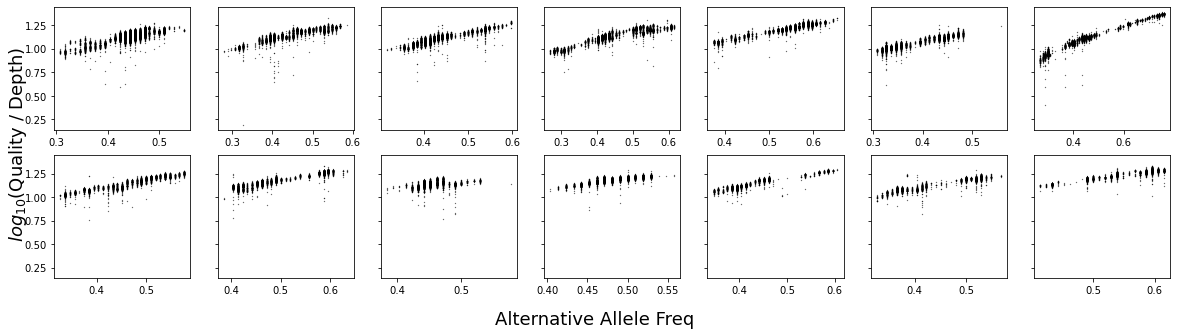

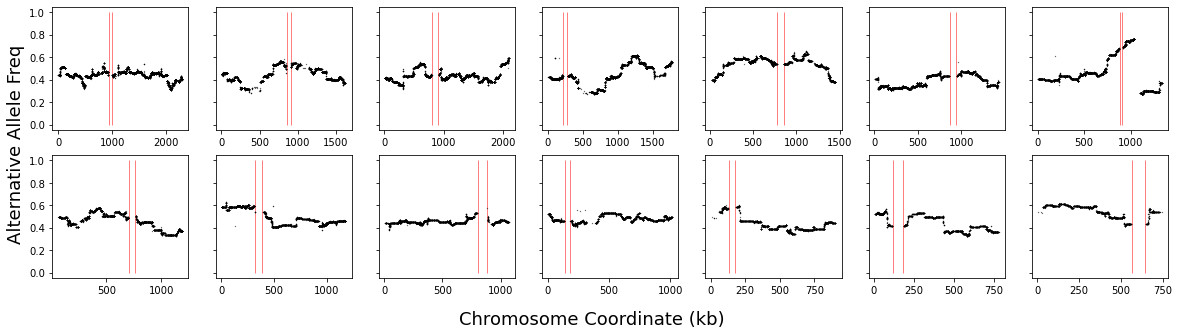

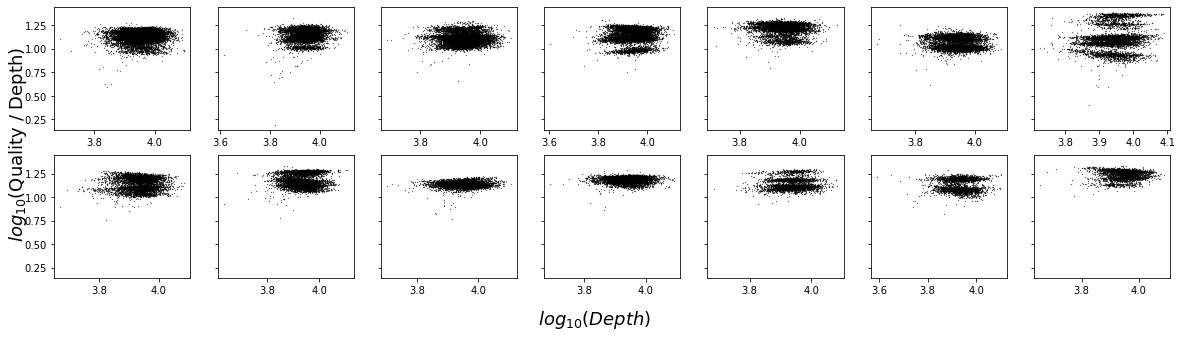

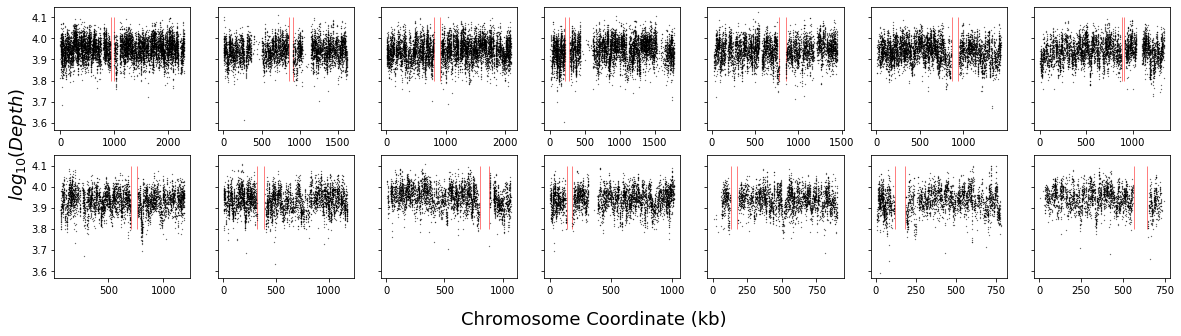

In [74]:
## Draw some pictures 
plot_chroms(snp_gt,chrom_list,xl='Alternative Allele Freq',x='AF')
plot_chroms(snp_gt,chrom_list,x='Posk',y='AF',yl='Alternative Allele Freq',centros=centros,vl=[0.0,1.0])
plot_chroms(snp_gt,chrom_list,xl='$log_{10}(Depth)$',x='Logdp')
plot_chroms(snp_gt,chrom_list,x='Posk',y='Logdp',yl='$log_{10}(Depth)$',centros=centros,vl=[3.8,4.1])

In [75]:
10**3.95/127

70.17723922312959

In [76]:
## filter on the log 10, depth normed quality per site and read depth
max_log_rd = 4.1
lqn = 0.75
fin_snp = snp_gt[(snp_gt['Lognq']>lqn) & (snp_gt['Logdp'] <max_log_rd)].copy()

In [77]:
## How many markers
fin_snp.shape

(92103, 119)

In [82]:
## Do we still have genotype changes?
fin_snp[this_cross['Ill-name']].sum().sum()

4397681.0

In [83]:
## recalculate the depths per site
fin_snp['Dps'] = ads_dfs_fn.loc[fin_snp.index].sum(axis=1)

In [84]:
## theck the length of the alt allele
fin_snp['Alt'].apply(len).unique()

array([ 3,  4,  5, 16, 15,  7, 10, 19,  9,  6,  8, 20, 13, 11, 14, 12, 17,
       18, 30, 22, 21, 24, 31, 28, 27, 33, 36, 29, 23, 32, 26, 25, 34, 43,
       44, 35, 39, 38, 40, 37, 45, 42])

In [85]:
## Edit the alt allele feild
#fin_snp['Alt'] = [a[1] for a in fin_snp['Alt'].tolist()]

In [86]:
## check the parental genotype sums, their are values we need to switch. 
fin_snp[parental].sum()

SS-A837-126    91481.0
SS-A853-127      622.0
SS-B830-128      622.0
dtype: float64

In [87]:
## Make another data column for allele that don't match reference
fin_snp['is_ref'] = [0 for i in fin_snp.index]
fin_snp.loc[(fin_snp[parental[0]]==0),'is_ref'] = 1

In [88]:
## Gather values to be switched
altr = fin_snp.loc[(fin_snp[parental[0]]==0),'Alt'].tolist()
refr = fin_snp.loc[(fin_snp[parental[0]]==0),'Ref'].tolist()
afr =  1 - fin_snp.loc[(fin_snp[parental[0]]==0),'AF'].values

In [89]:
## Swap the values
fin_snp.loc[(fin_snp[parental[0]]==0),'Alt'] = refr
fin_snp.loc[(fin_snp[parental[0]]==0),'Ref'] = altr
fin_snp.loc[(fin_snp[parental[0]]==0),'AF'] = afr

In [90]:
## Swich genotype coding values for these sites
fin_snp.loc[(fin_snp[parental[0]]==0),this_cross['Ill-name']] = abs(fin_snp.loc[
    (fin_snp[parental[0]]==0),this_cross['Ill-name']] - 1)

In [91]:
## check our work 
fin_snp[(fin_snp.is_ref==1)][parental].sum()

SS-A837-126    622.0
SS-A853-127      0.0
SS-B830-128      0.0
dtype: float64

In [92]:
## Seperate info and sample columns
info_cols = [c for c in fin_snp.columns if len(c.split('-')) < 3]
sample_cols = ['-'.join(c.split('-')[:-1]) 
               for c in fin_snp.columns if len(c.split('-')) == 3]

In [93]:
## check our work
assert len(info_cols) + len(sample_cols) == len(fin_snp.columns)

In [94]:
## make a list of sorted columsn
sortcols = [c for c in fin_snp.columns if len(c.split('-')) < 3] + [
    c for c in fin_snp.columns if len(c.split('-')) == 3]

In [95]:
## Sort the columns
fin_snp = fin_snp[sortcols]

In [96]:
## Rename columns
fin_snp.columns = info_cols + sample_cols

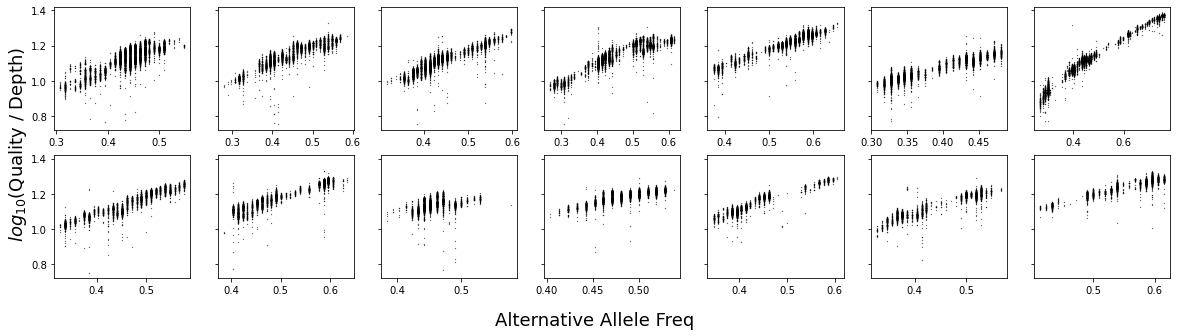

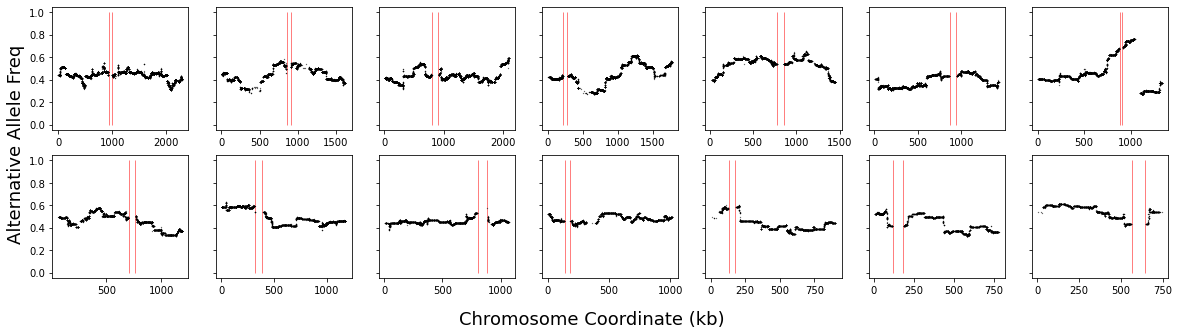

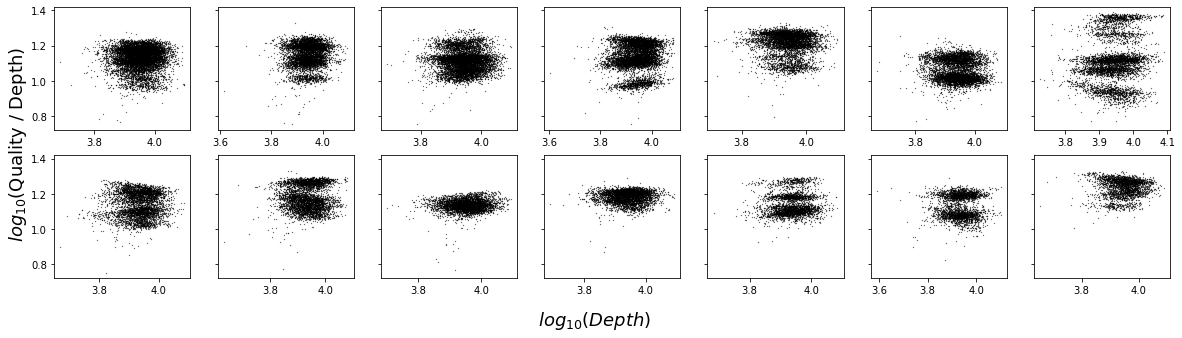

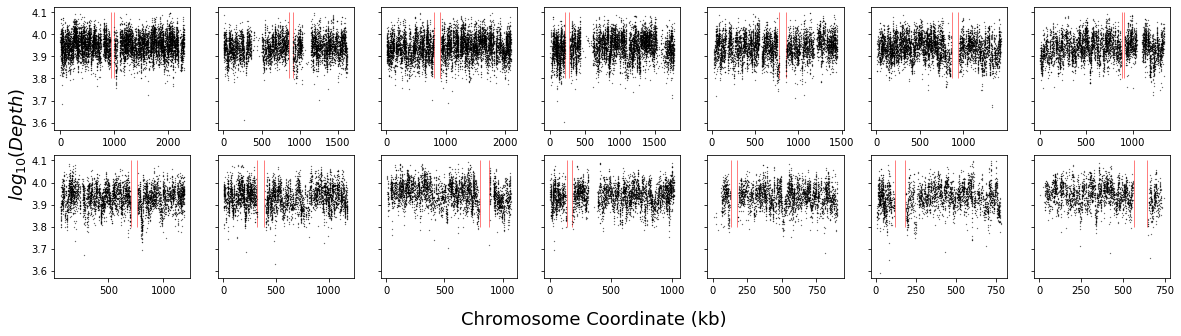

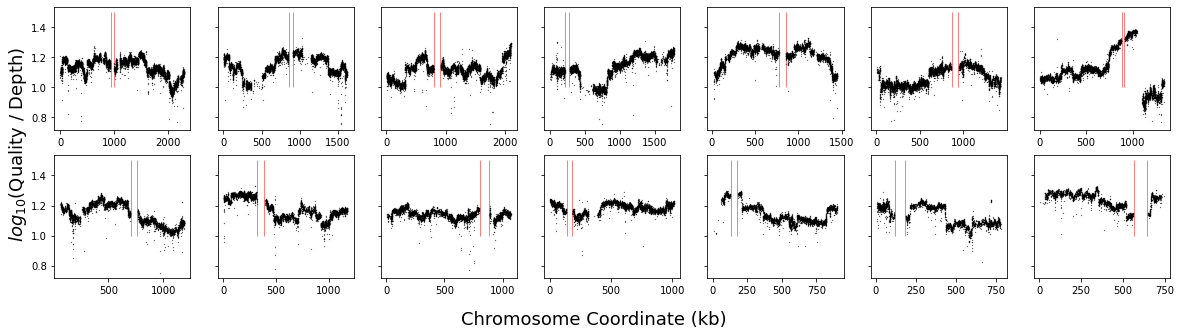

In [97]:
## Draw some pictures 
plot_chroms(fin_snp,chrom_list,xl='Alternative Allele Freq',x='AF')
plot_chroms(fin_snp,chrom_list,x='Posk',y='AF',yl='Alternative Allele Freq',centros=centros,vl=[0.0,1.0])
plot_chroms(fin_snp,chrom_list,xl='$log_{10}(Depth)$',x='Logdp')
plot_chroms(fin_snp,chrom_list,x='Posk',y='Logdp',yl='$log_{10}(Depth)$',centros=centros,vl=[3.8,4.1])
plot_chroms(fin_snp,chrom_list,x='Posk',y='Lognq',centros=centros,vl=[1,1.5])

In [98]:
## Convert all of the alternative alleles to a true string
fin_snp['Alt'] = [a.split('[')[-1].split(']')[0] 
                  for a in fin_snp['Alt'].tolist()]
fin_snp['Ref'] = [a.split('[')[-1].split(']')[0] 
                  for a in fin_snp['Ref'].tolist()]

In [99]:
## Make a start and end positions for the genetic variants
fin_snp['Start'] = fin_snp['Pos'] - 1 
fin_snp['End'] = fin_snp['Start'] + fin_snp['Ref'].apply(len)

In [100]:
## Reorder the columns
col_reorder = fin_snp.columns.tolist()[:17
        ] + fin_snp.columns.tolist()[-2:
            ] + fin_snp.columns.tolist()[17:-2]

In [101]:
## Check work
assert sum([a in col_reorder 
            for a in fin_snp.columns.tolist()]
          ) == fin_snp.shape[1]

In [102]:
## reorder the columns
fin_snp = fin_snp[col_reorder]

In [123]:
fin_snp.shape

(92103, 123)

In [127]:
fin_snp[[c for c in fin_snp.columns if c[:2]=='SS']
       ].drop_duplicates().shape

(2777, 104)

In [128]:
## make save path for variants
save_path = gvs_filepath+'CDx-ill-SNP-INDEL-df-%s.csv'%(
    len(this_cross['Ill-name']))

In [129]:
## Print the save path
save_path

'/Users/croth/Desktop/CRYPTO_QTL/FILES/CDx-ill-SNP-INDEL-df-104.csv'

In [ ]:
## Save the genotype dataframe
fin_snp.to_csv(save_path,index=True)

In [ ]:
## What is the finaly shape
fin_snp.shape

In [ ]:
## What do the first few rows look like
fin_snp.head()

In [ ]:
## List the coordinates for the peak under the QTL of chrom 2
ch2p = (848749,989618)

In [ ]:
## List the cooridnates of ssk1
xlssk1 = (930962,935444)
#jec21ssk1 = (930979,935461)

In [ ]:
## Gather SSk1 variants
ssk1 = fin_snp[(fin_snp.Chrom=='Chr02') & 
               (fin_snp.Start>=xlssk1[0]+1) & 
               (fin_snp.End<=xlssk1[1])].copy()

In [ ]:
## View the varnaints in ssk1
ssk1[['Chrom','Pos','Ref','Alt','Start','End']]